<a href="https://colab.research.google.com/github/schmcklr/skill_extractor/blob/main/(III)_text_preprocessing_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part III:** Text Preprocessing and Skill Analysis

The present program offers a variety of features designed to track and analyze the progression of desired job qualifications over time. The program should be executed in Google Colab with GPU acceleration enabled. There are three implemented analysis options for this:

1.   Frequency Analysis
2.   LDA Topic Modeling
3.   Dynamic Topic Modeling


# 1. Load data, applying filters & defining basic functions




1.1 Import of general preprocessed and translated job advertisements ([part 2](https://colab.research.google.com/drive/1EvylGHg4NLHiKnsAmW9l42AQUzLT2c5w#scrollTo=K2XUY2Qk6n7w&uniqifier=2))

In [1]:
!pip install --upgrade pandas --quiet
import pandas as pd

#Fetching preprocessed data
workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/job_data/job_data_preprocessed_extracted_qualifications_final.xlsx?raw=true'

# Import of tabs
job_data = pd.read_excel(workbook, sheet_name="Sheet1")

# Convert to lower case
job_data = job_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# Number of job advertisements before filtering
number_of_job_ads_before_filtering = str(len(job_data['description']))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 24.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.


<ipython-input-1-03115cb5ee6c>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  job_data = job_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)


### 1.2 Define Filters for analysis

In [2]:
# Keywords for title filtering
job_keywords_title = ["bpm", "process", "bpmn", "business process management", "bpm", "bpmn", "business process analysis", "process improvement", "process analysis", "business process"]
# Keywords for description filtering
job_keywords_description = ["business process management", "bpm", "bpmn", "process improvement", "process analysis", "business process"]

#######################################
# Filter #1: Filter job ads by keywords
#######################################
# Option (1): Filter job titles
#job_data = job_data[job_data['title'].str.contains('|'.join(job_keywords_title), case=False)]
#filter_type = 'title'
# Option (2): Filter job description
job_data = job_data[job_data['rawDescriptionTranslated'].str.contains('|'.join(job_keywords_description), case=False)]
filter_type = 'description'

##############################################################
# Filter #2: Filter for specific years (activated by default)
##############################################################
filter_for_years = True
years = [2015, 2018, 2019, 2020 ,2021, 2022]

#################################################################################
# Filter #3: Filter out internships/working student jobs (deactivated by default)
#################################################################################
student_keywords = ["internship", "working student", "intern", "practical", "praktikum"]
job_data = job_data[~job_data['title'].str.contains('|'.join(student_keywords), case=False)]

###################################################################################################
# Filter #4: Frequency Analysis: Filter descripton by predefined skill list (deactivated by default)
###################################################################################################
filter_by_skills = True


#########################################################################################################
# Coherence measurement: Can be helpful for detecting the tight number of topics (deactivated by default)
#########################################################################################################
calculate_coherence = True

# Extract the year from the 'date_column' and save it in a new column 'year'
job_data['year'] = job_data['created_at'].dt.year

# Filter out duplicates in 'qualifications', keeping only duplicates within the same year
job_data = job_data[~job_data.duplicated(subset=['qualifications', 'year'], keep='first')]

# User info (Number of job advertisements after filtering)
print('Filtering successfull! ' + str(len(job_data['description'])) + '/' + number_of_job_ads_before_filtering + ' Job advertisements are left.')

Filtering successfull! 1805/2840 Job advertisements are left.


### 1.3 Preview of filtered job data




In [3]:
# Displaying job data
import pandas as pd
from IPython.display import display, HTML

# Set pandas display option
pd.set_option('display.max_colwidth', None)

job_data_display = job_data[['title', 'qualifications', 'created_at']].copy()  # create an explicit copy

# Convert 'created_at' column to datetime format to make sure it's in the correct date format
job_data_display['created_at'] = pd.to_datetime(job_data_display['created_at'])

# Extract the year from the 'created_at' column and store it in a new column 'year'
job_data_display['year'] = job_data_display['created_at'].dt.year
job_data_display = job_data_display[['title', 'qualifications', 'year']]

# Get 5 random rows from the DataFrame
job_data_display = job_data_display.sample(5)

# Set text alignment
#job_data_display = job_data_display.style.set_properties(**{'text-align': 'left'}).set_table_styles([
#   dict(selector='th', props=[('text-align', 'left')])
#])

# Display DataFrame with HTML
display(HTML(job_data_display.to_html().replace('\\n','<br>')))

,title,qualifications,year
1526,junior data engineer,"...are a team player and a great communicator, able to translate business needs into analytical concepts and data requirements ...have relevant work experience in data analysis, business intelligence, or database management ...have basic knowledge of sql and enjoy wrangling data; scripting language experience a plus ...have a completed degree (msc/bsc) in management information systems (mis), or similar ...have worked with data from cloud software and api's",2020
345,junior business analyst trainee,"bachelor or master degree in a scientific, business or economic area french or dutch with good knowledge of english outstanding communication skills max 3 years of experience proactive and structured client oriented mindset analytical spirit",2018
1627,strategic account executive financial services uki (m/f/x),"...have a strong business acumen and are capable of developing and managing strategic plans with company executives - including c-level - and challenging the status quo ...are a real hunter and have a proven track record of success driving revenue through discovering, prospecting, creating new business and expansions ...are a visionary and would like to be part of this successful high growth journey with the #1 leading process mining saas company ...are excited about business processes, big data, data mining and process mining and introducing this new category to the market ...have excellent presentation skills and are able to communicate complex ideas effectively ...know the fs industry very well and can easily identify their business problems ...have experience managing long complex sales cycle with multiple stakeholders ...have closed multimillion deals with the top retail banks in the uki ...have 10+ years of experience selling complex enterprise software ...have a current outstanding network within the fs industry ...are passionate about our product and value proposition ...are fluent in written and spoken english",2020
121,information technology - fidessa developer,"experience of it technical analysis. ability to understand and analyze business processes & workflows with the objective of providing recommendations for the best use of technology to improve these strong knowledge of investment banking equities business, including trading, post trade clearance/settlement processing ability to work on their own and with a distributed team i.e. physically located in other regions strong working knowledge of the fidessa enterprise development model strong communications skills, both verbal and written perforce source control management softare expertise using tcl programming language exchange traded derivatives experience fidessa beam and ctac applications fidessa enterprise knowledge us listed options experience fix protocol java c++ c#",2016
1092,it services graduate programme,"you will need to have obtained or studying towards a 2:1 in any degree discipline, and have graduated by september 2020, as well as achieved 104 (260 pre-2017) ucas points for your a levels (or equivalent), a grade 4 (c) in english language and a grade 6 (b) in maths in your gcses (or equivalent).",2020


### 1.4 Initialise Lemmatizer

In [4]:
import nltk
import requests
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

# Initialise lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


### 1.5 Defining function for static LDA topic visualization
*   uses pyLDAvis to display gensim LDA topic models

In [5]:
# Downgrade Versions to be compatible with pyldavis (only if there is an error)
#!pip install numpy==1.22
#!pip install pandas==2.0.0

# Needed for topic visualization
!pip install --upgrade pyldavis --quiet
#!pip install pyLDAvis==2.1.2 --quiet
#!pip install --upgrade numpy --quiet
#!pip install --upgrade pandas --quiet


import pyLDAvis
import pyLDAvis.gensim_models
import webbrowser

# Function which allows visualization of topic modeling
def visualization_with_vis(lda_model, corpus, dictionary, name):
  vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds='mmds')
  pyLDAvis.enable_notebook()
  pyLDAvis.display(vis)
  pyLDAvis.save_html(vis, name + '.html')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 81.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.


# 2. Create skill list and skill extract function

Only be executed if filter_by_skills is active (deactivated by default):
*   Get skills from API (emsicloud)
*   Import of O*NET technology skills
*   Import od ESCO skills
*   Add list with custom skills
*   Define function for skill extraction

Always be executed:
*   Defining and Replacing skill synonyms









### 2.1 Connecting to Emsicloud (API)




In [6]:
if filter_by_skills:
  # Requesting access token
  url = "https://auth.emsicloud.com/connect/token"
  payload = "client_id=lwtnyxiuohd90aqc&client_secret=ZqV4d9LQ&grant_type=client_credentials&scope=emsi_open"
  headers = {'Content-Type': 'application/x-www-form-urlencoded'}
  response = requests.request("POST", url, data=payload, headers=headers)
  url = "https://emsiservices.com/skills/versions/latest/skills"

  # Storing access token
  access_token = response.json()["access_token"]

  # Requesting skill list
  querystring = {"fields": "name,type,category,subcategory", "limit": "100000"}
  headers = {'Authorization': 'Bearer ' + access_token}
  response = requests.request("GET", url, headers=headers, params=querystring)
  data = response.json()

  # Initialise skill array
  skills = []

  # Initialise skill dict
  skills_dict = {}

  # Add skills to skills_dict
  for entry in data["data"]:

      # Skill name
      if " (" in entry["name"]:
          name = lemmatizer.lemmatize(entry["name"].lower().replace('.','').split("_(")[0])
      else:
          name = lemmatizer.lemmatize(entry["name"].lower().replace('.',''))
      # Skill category
      if entry['category'] is None:
          category = 'other'
      elif entry['category']["name"] == 'NULL':
          category = 'other'
      else:
          category = entry['category']["name"]
      # Skill Subcategory
      if entry['subcategory'] is None:
          subcategory = 'other'
      elif entry['subcategory']["name"] == 'NULL':
          subcategory = 'other'
      else:
          subcategory = entry['subcategory']["name"]
      # Add skill information to skills_dict
      skills_dict[name] = {
          'name': name,
          'category': category,
          'subcategory': subcategory
      }

  # Add skills to array
  for entry in data["data"]:
    if " (" in entry["name"]:
      skill = lemmatizer.lemmatize(entry["name"].lower().replace('.','').split(" (")[0])
    else:
      skill = lemmatizer.lemmatize(entry["name"].lower().replace('.',''))
    skills.append(skill)

  # Store categories & subcategories
  categories = {}
  sub_categories = {}

  for skill in skills_dict.values():
      category = skill['category']
      if category not in categories:
          categories[category] = []
      categories[category].append(skill['name'])

  for skill in skills_dict.values():
      subcategory = skill['subcategory']
      if subcategory not in sub_categories:
          sub_categories[subcategory] = []
      sub_categories[subcategory].append(skill['name'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.2 Import of O*NET technology skills

In [7]:
if filter_by_skills:
  import pandas as pd

  # Import technology skills raw data
  skills_onet_workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/skill_data/skills_onet.xlsx?raw=true'

  # Import of tabs
  skills_onet = pd.read_excel(skills_onet_workbook, sheet_name="Technology Skills")

  # Convert to list
  skills_onet = skills_onet['Example'].str.lower().tolist()

  # Append to skill list
  skills += skills_onet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.3 Import of ESCO skills

In [8]:
if filter_by_skills:
  !pip install odfpy --quiet
  import pandas as pd

  # Import ESCO skills raw data
  skills_esco_workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/skill_data/skills_esco.ods?raw=true'

  # Import of tabs
  skills_esco = pd.read_excel(skills_esco_workbook, sheet_name="Skills")

  # Convert to list
  skills_esco = skills_esco['preferredLabel'].str.lower().tolist()

  # Append to skill list
  skills += skills_esco

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### 2.4 Extend list with custom skills

*   Creating own skill list
*   Replace blanks in compound skills with '_' to recognise them as one token
*   Definition of the skills defined in the Gartner Skillset
*   Convert to set remove duplicates and get faster access




In [9]:
if filter_by_skills:
  from re import U
  # Creating own skill list
  other_skills = ['python', 'c++', 'c', 'r', 'java', 'hadoop', 'scala', 'flask', 'pandas', 'spark', 'scikit-learn',
                  'numpy', 'php', 'sql', 'mysql', 'css', 'mongdb', 'nltk', 'fastai', 'keras', 'pytorch', 'tensorflow',
                  'ruby', 'javascript', 'django', 'react', 'reactjs', 'ai', 'ui', 'tableau', 'crm', 'modeling',
                  'bpm', 'vision', 'communication', 'analysis', 'design', 'excel', 'itil', 'data',
                  'governance', 'police', 'simulation', 'automation', 'kpi', 'erp', 'statistic', 'sap', 'german',
                  'english', 'kafka', 'api', 'rest', 'database', 'metrics', 'autonomy']

  # Creating composed skills (needed for lemmatization that words considered as one word)
  composite_skills = ['process_modeling', 'application_development', 'change_techniques', 'business_case',
                      'business_process_improvement', 'business_process', 'team_player', 'web_development',
                      'quality_management']

  # Custom list for BPM Gartner skill set
  gartner_skill_set = ['business_case', 'business_process', 'project_management', 'organizational', 'communication',
                      'change_management', 'process_discovery', 'process_mod', 'extract_data', 'data_visualization',
                      'architecture', 'bpmn', 'bpm', 'agile_development', 'optimization', 'user_experience', 'ui','process_management'
                      ]

  # Extending skill list fetched from Emsi and O*NET
  skills += other_skills
  skills += composite_skills
  skills += gartner_skill_set

  # Replace the blanks with '_' to recognise compound skills
  for i in range(len(skills)):
    skills[i] = skills[i].replace(" ", "_")

  # Convert to set remove duplicates and get faster access
  skills = set(skills)

  # Number of unique skill terms
  print('Number of unique skills: ' + str(len(skills)))

Number of unique skills: 54657


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.5 Create list with skill synonyms


In [10]:
skill_synonyms = {
    'artificial_intelligence' : ['ai', 'artifical_intelligence'],
    'user_interface': ['ui'],
    'business_process_management': ['bpmn', 'bpm'],
    #'english_language': ['english', 'fluent_english'],
    #'german_language': ['german'],
    'microsoft_excel': ['excel', 'especially_excel'],
    'crm': ['customer_relationship_management'],
    'business_intelligence': ['bi'],
    'sap_fi': ['fi'],
    'sap_hana': ['hana'],
    'powerpoint': ['power_point'],
    'bachelor_degree': ['bachelor'],
    'master_degree': ['master'],
    #'communication_skill': ['communication', 'strong_communication', 'communicate', 'communication_strength', 'communicative'],
    'analytical_skill': ['analytical'],
    'automation': ['automation_anywhere'],
    'team_player': ['team', 'teamwork'],
    'power_bi': ['powerbi'],
}

skill_synonyms_frequency_analysis = {
    'artificial_intelligence' : ['ai', 'artifical_intelligence'],
    'user_interface': ['ui'],
    'business_process_management': ['bpmn', 'bpm'],
    'english_language': ['english', 'fluent_english', 'englisch'],
    'german_language': ['german'],
    'microsoft_excel': ['excel', 'especially_excel'],
    'crm': ['customer_relationship_management'],
    'business_intelligence': ['bi'],
    'sap_fi': ['fi'],
    'sap_hana': ['hana'],
    'powerpoint': ['power_point'],
    'bachelor_degree': ['bachelor'],
    'master_degree': ['master'],
    'communication': ['communication_skill', 'strong_communication', 'communicate', 'communication_strength', 'communicative'],
    'analytical_skill': ['analytical'],
    'automation': ['automation_anywhere'],
    'team_player': ['team', 'teamwork'],
    'power_bi': ['powerbi'],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.6 Function for replacing skill synonyms

In [11]:
# Function for replacing synonym skills
def replace_synonym_skills(filtered_docs, skill_synonyms):
    for doc in filtered_docs:
        for i in range(len(doc)):
            for key in skill_synonyms.keys():
                if doc[i] in skill_synonyms[key]:
                    doc[i] = key
                    break
    return filtered_docs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 3. Text preprocessing


*  Define stopwords and stopwords removal function  
*  Define function for special character removing
*  Split job dataframe by year
*  Text Preprossesing
*  Compute bigrams, trigrams with gensim phraser
*  Define and revert phrases to be ignored


### 3.1 Define stopwords and removal functions  





*   3.1.1 Defining stopword list


In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# English stopwords
english_stopwords = stopwords.words('english')

# German stopwords
german_stopwords = stopwords.words('german')

# Custom stopwords list
custom_stop_words = ['genetics','go', 'public', 'transport', 'pregnancy','cash', 'le', 'register', 'make', 'm', 'nice', 'work', 'b',
                    'client', 'skill', 'good', 'allianz', 'celonis', 'internship', 'opportunity', 'robotics', 'billing', 'talent'
                    'chemistry', 'disability',  'working', 'offer', 'product', 'requirement', 'und', 'toyota', '1st', 'paris',
                    'investment', 'consulting', 'banking', 'merchandising', 'stock', 'amazon', 'are', 'amadeus', 'oe', 'must', 'celonis', 'are',
                    'automotive', 'safe', 'best', 'privacy', 'well', 'work', 'strong', 'commercial', 'dealer', 'you', 'none', 'entry', 'level',
                    'br', 'kpmg', 'complex', 'ability', 'experience', 'first', 'high', 'relevant', 'system', 'excellent',
                    'use', 'personal', 'knowledge', 'understanding', 'plus', '#', 'br_br', 'e_g', 'ideally', 'amazon_equal'
                    'able', 'year', 'school', 'scor', 'required', 'new', 'position', 'bull', 'br', 'already', 'gained', 'looking',
                    'already_gained', 'would', 'win', 'field', 'br_bull', 'e', 'de', 'etc', '#_#', 'within', 'company', 'background', 'ee',
                    'great', 'et', 'month', 'candidate', 'enviroment', 'uf0b7', 'fluent', 'need', 'ä',
                    'n', 'free', 'part', 'point', 'car', 'like', 'would_plus', 'understand', 'want', 'last', 'g', 'alytics', '+2',
                    'month_full', 'using', 'f', 'availability', 'http_www', 'closely', 'mercedes-benz', 'sixt', 'need_choose', '++',
                    'area', 'customer', 'industry', 'able', 'equivalent', 'including', 'related', 'stakeholder', 'proven', 'preferably',
                    'oriented', 'change', 'time', 'interest', 'preferred', 'similar', 'role', 'basic', 'focus', 'expertise', 'advantage',
                    'drive', 'know', 'hand', 'multiple', 'gap_year', 'way_working', 'full', 'medium', 'office', 'tool', 'structured',
                    'comparable', 'least', 'pronounced', 'bring', 'year_professional', 'chemistry', 'lufthansa', '+49', 'yes','degree','end',
                    'solution', 'previous', 'drive_celonis', 'celonis','unicredit', 'bank','application', 'sale'

                    #'business','management','process'


                    ]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*   3.1.2 Defining functions for stopword removal


In [13]:
import re

# Function for removing stopwords from dataframe
def remove_stopwords(doc):
  filtered_doc = []
  filtered_doc = [token for token in doc if token not in english_stopwords and token not in german_stopwords]
  return filtered_doc

# Function for removing custom stopwords from dataframe
def remove_custom_stopwords(doc):
  filtered_doc = []
  filtered_doc = [token for token in doc if token not in custom_stop_words]
  return filtered_doc

# Function for removing tokens that only contain numbers
def remove_numeric_tokens(tokens):
    return [token for token in tokens if not bool(re.match(r'^[0-9]+$', token))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.2 Function for url and special character removing




* Function for url removal

In [14]:
def remove_links(text):
    # Define a regular expression pattern to detect URLs
    url_pattern = r'https?://\S+|www\.\S+'

    # Replace URLs in the text with spaces
    text_without_links = re.sub(url_pattern, ' ', text)

    return text_without_links

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Function for special character removing

In [15]:
import re

# List of exceptions (combinations that should not be removed)
exceptions = ['c++', 'c#']

# Function to remove special characters while considering exceptions for individual tokens
def remove_special_characters(tokens):
    # Create a regular expression to remove special characters
    special_characters_pattern = r'[^\w\s]'

    # Create a regular expression for exceptions
    exceptions_pattern = '|'.join(re.escape(exception) for exception in exceptions)

    # Initialize a list to store the cleaned tokens
    cleaned_tokens = []

    for token in tokens:
        # Combine the two regular expressions and remove special characters,
        # but keep the exceptions unchanged
        cleaned_token = re.sub(f'({exceptions_pattern})|(?:{special_characters_pattern})', r'\1', token)
        cleaned_tokens.append(cleaned_token)

    return cleaned_tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.3 Split job dataframe by year

In [16]:
# Group the DataFrame by year
grouped = job_data.groupby(job_data['created_at'].dt.year)

# Create a dictionary to store the new DataFrames
year_dfs = {}

# Split groups into separate dataframes and store them in a dictionary
for year, group in grouped:
    year_dfs[year] = group.copy()

# Filter by years
if filter_for_years:
  year_dfs = {year: df for year, df in year_dfs.items() if year in years}

# Number of jobs ads per year before text preprocessing
number_of_ads_per_year = {}
for year in year_dfs:
  number_of_ads_per_year[year] = len(year_dfs[year]['qualifications'])

# User Info (Number of job ads per year)
print(number_of_ads_per_year)

{2015: 87, 2018: 146, 2019: 387, 2020: 495, 2021: 510, 2022: 134}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.4 Text Preprossesing
*   Remove URLs
*   Tokenize documents
*   Remove numbers, but not words that contain numbers
*   Remove stopwords
*   Lemmatization


In [17]:
!pip install spacy --quiet
nltk.download('omw-1.4');
nltk.download('wordnet');
nltk.download('punkt');
import spacy
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# Create list whith all documents for tasks like computing bigrams/trigrams
docs_all = []
filtered_docs_all = []
docs_by_year = {}
docs_by_year_frequency_analysis = {}
filtered_docs_all_frequency_analysis = []
new_doc_complete_all = []
filtered_docs_all_corpus = []

# Preprossesing based on year
for year in year_dfs:

  docs = list(year_dfs[year]['qualifications'])

  # Remove URLs from text
  docs = [remove_links(doc) for doc in docs]

  # Tokenize the documents
  tokenizer = RegexpTokenizer(r'[\w#+]+')
  for idx in range(len(docs)):
      docs[idx] = docs[idx].lower()  # Convert to lowercase
      docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words

  # Remove numbers, but not words that contain numbers
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

  # Remove words that are only one character
  docs = [[token for token in doc if len(token) > 1 or token in ['r', 'c']] for doc in docs]

  # Innizialise lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Lemmatize the documents
  docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

  # Remove stopwords
  docs = [remove_stopwords(doc) for doc in docs]

  # Remove special characters
  docs = [remove_special_characters(doc) for doc in docs]

  # Add processed docs to docs_by_year dict
  docs_by_year[year] = docs

  # Add processed docs to docs_all list (used for overall lda model and bigram/trigram calculation)
  docs_all += docs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 3.5 Compute bigrams, trigrams with gensim phraser

In [18]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

# Compute bigrams
bigram = Phrases(docs_all, min_count=15)#, threshold=6)
# Compute trigrams
trigram = Phrases(docs_all, min_count=15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred

* Define phrases to be ignored and function to revert unwanted phrases




In [19]:
# Define word pairs to be ignored within the phrases creation
ignored_phrases = ['german_english', 'example_sentence', 'bachelor_master', 'verbal_written', 'written_spoken', 'english_german', 'spoken_written',
'written_verbal', 'oral_written', 'word_excel', 'fluency_english', 'dutch_french', 'python_r', 'excel_powerpoint', 'economics_mathematics',
'end_end', 'french_dutch', 'advanced_excel', 'lean_six', 'excel_word', 'powerpoint_excel', 'javascript_html', 'mathematics_comparable',
'mathematics_statitic', 'html5_cs', 'automation_anywhere', 'write_english', 'english_fluently']

# Revert unwanted phrases back into individual words in the document
def revert_unwanted_phrases(doc, ignored_phrases):
  for phrase in doc:
    if '_' in phrase and phrase in ignored_phrases:
        word1, word2 = phrase.split('_')
        index = doc.index(phrase)  # Index of the original trigram
        doc.remove(phrase)  # Remove the original trigram
        doc.insert(index, word1)  # Insert the first word at the original position
        doc.insert(index + 1, word2)  # Insert the second word right after
  return doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.6 Token Filtering
*   Creating bigrams/trigrams
*   There are options for token filterung for Frequency Analyses:
  *   Use all words, except stopwords (default)
*   replace synonym skills
*   remove custom stopwords
*   remove empty docs



In [20]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

# Preprossesing based on year
for year in docs_by_year:

  # Load docs for year
  docs = docs_by_year[year]

  # Creating bigrams/trigrams, filter out phrases that should be ignored
  for idx in range(len(docs)):
      # Creating bigrams/trigrams calculated by gensim phraser
      docs[idx] = trigram[bigram[docs[idx]]]
      # Filter out phrases that should be ignored
      docs[idx] = revert_unwanted_phrases(docs[idx], ignored_phrases)

  # Store filtered docs
  filtered_docs = []

  # Filter docs
  for doc in docs:
      # Define tokens
      tokens = doc

      # Use all words, except custom stopwords (default)
      new_tokens = [token for token in tokens]

      # POS-Filtering (default: Exclude Verbs)
      tagged_tokens = pos_tag(new_tokens)
      # Filter and keep all words except verbs
      new_tokens = [token for token, tag in tagged_tokens if not tag.startswith('VB')]

      # Convert list of tokens into a string and add it to the new list of documents
      filtered_docs.append(new_tokens)

  # Replace synonym skills basic (used for topic modeling)
  filtered_docs = replace_synonym_skills(filtered_docs, skill_synonyms)

  # Remove Custom Stopwords
  filtered_docs = [remove_custom_stopwords(doc) for doc in filtered_docs]

  # Remove empty docs and docs with less than 250 characters
  filtered_docs = [doc for doc in filtered_docs if doc and len(' '.join(doc)) >= 250]

  # Store filtered docs by year
  docs_by_year[year] = filtered_docs

  # Store filtered docs for the entire period
  filtered_docs_all += filtered_docs

# Store filtered docs for frequency analysis
docs_by_year_frequency_analysis = docs_by_year

# Replace synonym skills advanced (used for frequency analysis)
for year, docs in docs_by_year_frequency_analysis.items():
  docs_by_year_frequency_analysis_replace_synonym_skills = replace_synonym_skills(docs, skill_synonyms_frequency_analysis)
  docs_by_year_frequency_analysis[year] = docs_by_year_frequency_analysis_replace_synonym_skills
  filtered_docs_all_frequency_analysis += docs_by_year_frequency_analysis_replace_synonym_skills

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### 3.7 Document statistics
* number of documents
* tokens per document
* characters er document

* Number of job postings per year

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-21-a0ab840d4945>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color2 = plt.cm.get_cmap('Reds')(0.4)  # Adjust the saturation here (0.5 means 50% saturation)


<Figure size 1000x500 with 0 Axes>

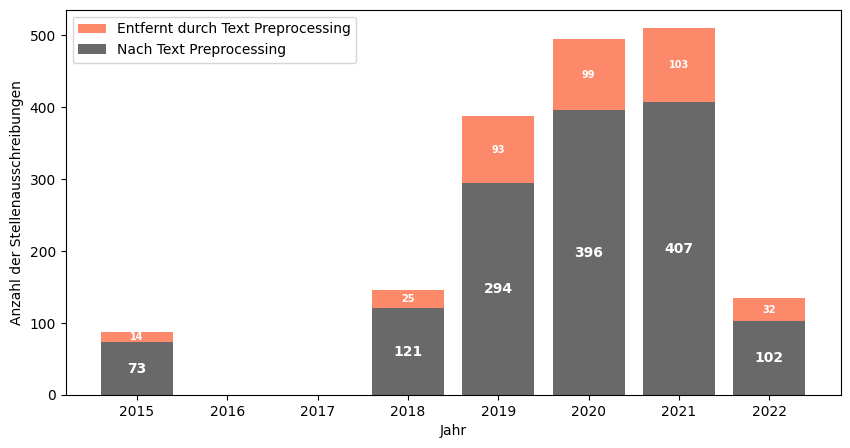

In [21]:
import matplotlib.pyplot as plt

# Number of jobs ads per year after text preprocessing
number_of_ads_per_year_after_prepro = {}
for year in docs_by_year:
  number_of_ads_per_year_after_prepro[year] = len(docs_by_year[year])

# Set colors
color = '#696969'
color2 = plt.cm.get_cmap('Reds')(0.4)  # Adjust the saturation here (0.5 means 50% saturation)


# Sort the data by years
sorted_data = sorted(number_of_ads_per_year_after_prepro.items())
sorted_data_before_prepro = sorted(number_of_ads_per_year.items())


# Creating a figure object
fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,5))


# Creating bar plot with jobs ads per year before text preprocessing
years_before_prepro = [x[0] for x in sorted_data_before_prepro]
counts_before_prepro = [x[1] for x in sorted_data_before_prepro]
bars_before_prepro = ax.bar(years_before_prepro, counts_before_prepro, color=color2, label='Entfernt durch Text Preprocessing')

# Creating bar plot with jobs ads per year after text preprocessing
years = [x[0] for x in sorted_data]
counts = [x[1] for x in sorted_data]
bars = ax.bar(years, counts, color=color,label='Nach Text Preprocessing')

# Set lable for number of postings
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height/2, int(height),
            ha='center', va='center', color='white', fontweight='bold', fontsize=10)


# Set lable for number of postings before preprocessing
for i, bar in enumerate(bars_before_prepro):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., counts[i] + (height - counts[i])/2, (str(int(height - counts[i]))),
            ha='center', va='center', color='white', fontweight='bold', fontsize=7)


# Set axis, labels, legend and title
ax.set_xlabel('Jahr', fontsize=10)
ax.set_ylabel('Anzahl der Stellenausschreibungen', fontsize=10)
ax.legend()
#plt.title("Number of job postings by year", fontsize=16)

# Display chart
plt.show()

* Tokens per document

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1000x500 with 0 Axes>

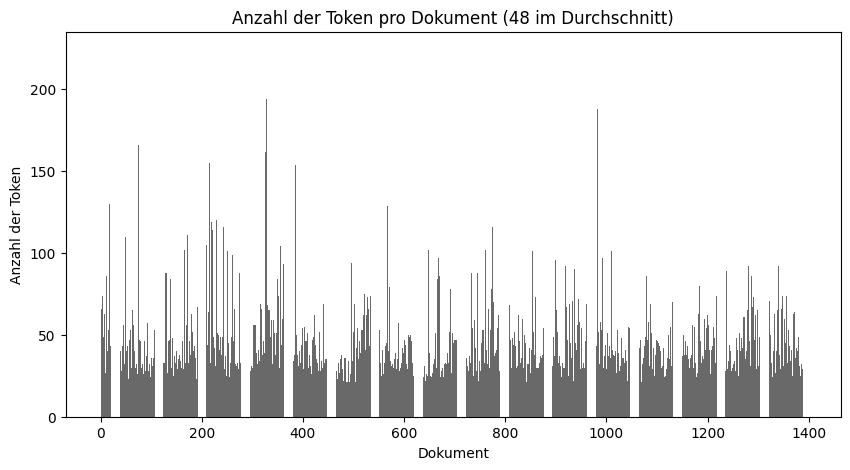

In [22]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(10, 5))

# Create subplots within the figure with a specific size
fig, ax = plt.subplots(figsize=(10, 5))

# Determine the number of tokens per document
token_counts = [len(doc) for doc in filtered_docs_all]

# Create an index for the x-axis
x = range(1, len(filtered_docs_all) + 1)

# Calculate the token mean
mean = sum(token_counts) / len(token_counts)

# Create the chart and define labels
plt.bar(x, token_counts,color=color)
plt.xlabel('Dokument')
plt.ylabel('Anzahl der Token')
plt.title('Anzahl der Token pro Dokument (' + f"{mean:.0f} im Durchschnitt)")
plt.show()

*  Characters per document

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


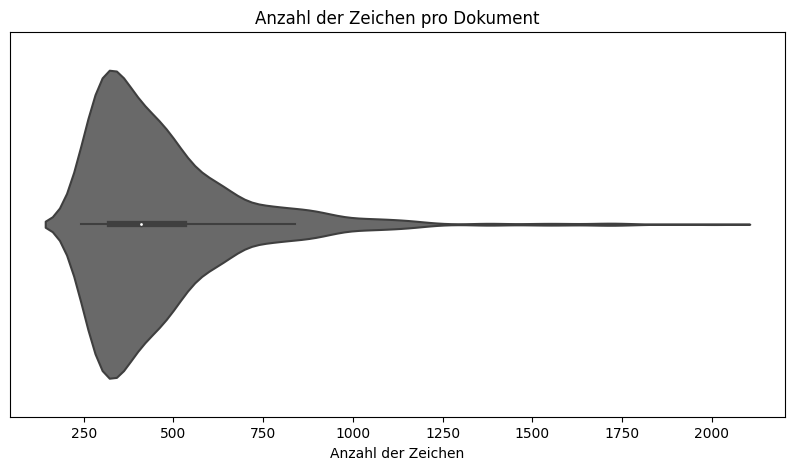

Min: 243
Max: 2006
Median: 409
Durchschnitt: 465


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

# Zeichenanzahl pro Dokument (ohne Unterstrich "_")
char_counts = [len(" ".join(doc).replace("_", "")) for doc in filtered_docs_all]

# Erstellen Sie den horizontalen Violinplot
plt.figure(figsize=(10, 5))
sns.violinplot(x=char_counts, color=color, orient="h")

#plt.ylabel('Dokument')
plt.yticks([])
plt.xlabel('Anzahl der Zeichen')
plt.title('Anzahl der Zeichen pro Dokument')

plt.show()

# Berechnen Sie Min, Max, Median und Durchschnitt
min_value = min(char_counts)
max_value = max(char_counts)
median_value = statistics.median(char_counts)
mean_value = statistics.mean(char_counts)

# Ausgabe der Werte als Text unter dem Plot
print(f'Min: {min_value}')
print(f'Max: {max_value}')
print(f'Median: {median_value}')
print(f'Durchschnitt: {mean_value:.0f}')

# 4. Frequency Analysis


*  Word Cloud: A visual representation of the most frequent words
*  Interactive Chart for Frequency Analysis: Interactively filtering and examining data


### 4.1 Wordcloud representation for each year

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from ipywidgets import interact, widgets

# Define colors
color_list = [
    "#336699", "#993366", "#cc6600", "#cc3366",
    "#99cc33", "#cc9999", "#3399cc", "#ff9900",
    "#669933", "#ff6633", "#66cccc", "#cc6600",
    "#993300", "#33cccc", "#ff3366", "#66cc66",
    "#ff3333", "#3366cc"
]

color_index = 0

# Generate next color
def generate_next_color():
    global color_index
    if color_index >= len(color_list):
        raise ValueError("All colors have been used.")

    next_color = color_list[color_index]
    color_index += 1
    return next_color

# Generate color mapping for each year
colors = {year: generate_next_color() for year in docs_by_year_frequency_analysis.keys()}

# Generate wordcloud
def generate_wordcloud(year):
    docs_list = docs_by_year_frequency_analysis[year]
    docs = [word for sublist in docs_list for word in sublist]
    text = ' '.join(docs)

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          min_font_size=5,
                          colormap='viridis',  # You can choose a different colormap here
                          color_func=lambda *args, **kwargs: colors[year]).generate(text)  # Color customization

    # Display the wordcloud
    plt.figure(figsize=(10, 4), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    #plt.title(f"Wordcloud for Year {year}", color=colors[year], fontsize=20)
    plt.show()

# Interactive slider function
interact(generate_wordcloud, year=widgets.Dropdown(options=docs_by_year.keys()));

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


interactive(children=(Dropdown(description='year', options=(2015, 2018, 2019, 2020, 2021, 2022), value=2015), …

### 4.2 Interactive Chart for Frequency Analysis

In [25]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel


# Create dictionary representation of the documents
dictionary = Dictionary(filtered_docs_all_frequency_analysis)
# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in filtered_docs_all_frequency_analysis]


# Extract the frequency of each token from the corpus
token_frequencies = {}
for doc in corpus:
    tokens_in_doc = set()
    for token_id, freq in doc:
        token = dictionary[token_id]
        if token not in tokens_in_doc:
            tokens_in_doc.add(token)
            if token in token_frequencies:
                token_frequencies[token] += 1
            else:
                token_frequencies[token] = 1

# Sort the tokens by descending frequency
token_freqs_overall = []
token_freqs_overall = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Calculates token frequencies for each year (token is counted once per document)

In [26]:
import warnings
from gensim.models import LdaModel
from gensim.models.phrases import Phrases

# Ignore warning caused by gensim library, improve readability
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Store token frequencies for each year
token_freqs = {}

# Analysis based on year
for year in docs_by_year:

  docs = docs_by_year[year]

  # Create a dictionary representation of the documents
  dictionary = Dictionary(docs)

  # Bag-of-words representation of the documents
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  # Extract the frequency of each token from the corpus (only counted once per doc)
  token_frequencies = {}
  for doc in corpus:
      tokens_in_doc = []
      tokens_in_doc = set()
      for token_id, freq in doc:
          token = dictionary[token_id]
          if token not in tokens_in_doc:
              tokens_in_doc.add(token)
              if token in token_frequencies:
                  token_frequencies[token] += 1
              else:
                  token_frequencies[token] = 1


  # Sort the tokens by descending frequency
  sorted_tokens = []
  sorted_tokens = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)
  token_freqs[year] = sorted_tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Determining the percentage of advertisements that mentioned skills

In [27]:
# Create list to store all extracted skills
most_mentioned_skills = []
for token, freq in token_freqs_overall:
  most_mentioned_skills.append(token)

# Create dict to store the calculated value by year (in which percentage of advertisements is the skill required)
most_mentioned_skills_per_year = {}

# Calculate percentage for each skill in each year
for skill in most_mentioned_skills:
  for year in token_freqs:
    value = 0
    for term, count in token_freqs[year]:
      if skill == term:
        value = count/number_of_ads_per_year[year]
        break
    if skill in most_mentioned_skills_per_year:
      most_mentioned_skills_per_year[skill].append(value)
    else:
      most_mentioned_skills_per_year[skill] = []
      most_mentioned_skills_per_year[skill].append(value)

##### Visualisation the development of tokens over time (Frequency Analysis)

  *   Shows the percentage of documents per year in which a token appears
  *   Filtering can be applied using a list of predefined skills
  *   Search can be used to search for a specific skill

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

# X-axis
years = np.array(list(token_freqs.keys()))

# Create a checkbox list for skills
skills_list = list(most_mentioned_skills_per_year.keys())
skills_checkboxes = widgets.SelectMultiple(
    options=skills_list,
    value=[skills_list[0]],  # Default value for initial selection
    rows=6,
    description='Token:',
    disabled=False,
    layout=widgets.Layout(height='100px')
)

# Create checkboxes for filtering skills
filtered_skill_list = skills_list

# Create a button to apply the filter
filter_for_skills_button = widgets.Button(description="Filter for Skills")
unfilter_for_skills_button = widgets.Button(description="All Token")

# Create a function to update the skills list based on the filter
def update_skills_list_filter(button_click):
    selected_skills = [skill for skill in skills_list if skill in skills]
    skills_checkboxes.options = selected_skills
    skills_checkboxes.value = [selected_skills[0]]
    skills_checkboxes.description = 'Skills:'
    filtered_skill_list = selected_skills
    # Reset search
    search_text.value = ""

def update_skills_list_unfilter(button_click):
    selected_skills = [skill for skill in skills_list]
    skills_checkboxes.options = selected_skills
    skills_checkboxes.value = [selected_skills[0]]
    skills_checkboxes.description = 'Token:'
    filtered_skill_list = selected_skills
    # Reset search
    search_text.value = ""


# Link the button click to the function to update the skills list
filter_for_skills_button.on_click(update_skills_list_filter)
unfilter_for_skills_button.on_click(update_skills_list_unfilter)

# Create a text input field for searching
search_text = widgets.Text(
    placeholder='Search',
    description='Search:',
    disabled=False
)

# Create a function to update the skills list based on the search input
def update_skills_list_search(change):
    search_value = change.new.lower()  # Get the lowercase search input
    filtered_skills = [skill for skill in filtered_skill_list if search_value in skill.lower()]
    skills_checkboxes.options = filtered_skills
    if filtered_skills:
      skills_checkboxes.value = [filtered_skills[0]]

# Link the text input to the search function
search_text.observe(update_skills_list_search, names='value')


# Create a function to plot the selected skills
def plot_skills(skills):
    plt.clf()  # Clear the old plot

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    for skill in skills:
        skill_data = np.array(most_mentioned_skills_per_year[skill])
        ax.plot(years, skill_data, label=skill)

        # Add the percentage as a label for each data point
        for i, data_point in enumerate(skill_data):
            ax.text(years[i], data_point, f"{data_point:.1%}", ha='center', va='bottom', fontsize=10)

    # Set the x-axis ticks to correspond to the year values
    ax.set_xticks(years)

    # Label the axes
    ax.set_xlabel("Jahr")
    ax.set_ylabel("Anteil an Stellenanzeigen (%)")

    # Add legend and show plot
    ax.legend()
    plt.show()

# Create an interactive widget to link the function and the checkboxes
interactive_plot = widgets.interactive(plot_skills, skills=skills_checkboxes)

# Create an HBox to display the buttons side by side
button_box = widgets.HBox([unfilter_for_skills_button, filter_for_skills_button, search_text])

# Display the widgets
if filter_by_skills:
  display(button_box)
display(interactive_plot)

interactive(children=(SelectMultiple(description='Token:', index=(0,), layout=Layout(height='100px'), options=…

# 5. LDA Topic Modeling


*   gensim or tomotopy framework can be used (default: tomotopy)





### 5.1 Setting Model parameters

In [29]:
import numpy as np

# Set training parameters
num_topics = 7 # Specifies the number of topics to be extracted from the corpus
min_cf = 15 # minimum collection frequency of words, words with a smaller collection frequency are excluded
min_df = 10 # minimum document frequency of words, words with a smaller document frequency are excluded
rm_top = 5 # the number of top words to be removed

# Number of keywords per topic to display
num_keywords = 20

# Setting the seed to ensure the reproducibility of the results
seed = 22
np.random.seed(seed)

### 5.2 LDA Topic Modeling (tomotopy)

In [30]:
!pip install tomotopy
import tomotopy as tp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.6 MB/s eta 0:00:00


#### 5.2.1 Setting up model

* Use pretrained model (optional)

In [31]:
import os
from ipywidgets import interact, widgets

# Define the directory where the repository folder will be downloaded
download_path = '/content/repository_folder/'

# Specify the URL of the GitHub repository
repository_url = 'https://github.com/schmcklr/skill_extractor.git'

# Download the repository
os.system(f'git clone {repository_url} {download_path}')

# Select trained LDA models
lda_models_pretrained = [file for file in os.listdir('/content/repository_folder/trained_models') if "lda" in file.lower()]

# Dropdown widget
dropdown_lda = widgets.Dropdown(
    options=lda_models_pretrained,
    description='Select Trained Model:',
    disabled=False,
    layout={'width': '500px'},
    style={'description_width': 'auto'}
)

# Add default option
additional_option = ""
dropdown_lda.options = [additional_option] + list(dropdown_lda.options)

# Display dropdown
display(dropdown_lda)

Dropdown(description='Select Trained Model:', layout=Layout(width='500px'), options=('', 'filtered_by_descript…

* Train new model (default)

In [32]:
# Train new model
if dropdown_lda.value == "":
  # Convert the list of lists into a list of strings
  list_of_strings = [' '.join(doc) for doc in filtered_docs_all]

  corpus = []
  # Creating corpus instance
  corpus = tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer())

  # Processing list of strings into correct format
  corpus.process(list_of_strings)

  # Create an LDA model and train it
  mdl = tp.LDAModel(k=num_topics, # Specifies the number of topics to be extracted from the corpus
                    min_cf=min_cf, # minimum collection frequency of words, words with a smaller collection frequency are excluded
                    min_df=min_df, # minimum document frequency of words, words with a smaller document frequency are excluded
                    corpus=corpus, # list of documents
                    seed=seed, # random seed
                    rm_top=rm_top # the number of top words to be removed
                    )

  # Train model
  mdl.train(1000)

  # Printing model summary (developing context only)
  #print('Number of documents:', len(mdl.docs), ', Vocabulary size:', len(mdl.used_vocabs), ', Number of words:', mdl.num_words)
  #print('Removed top words:', mdl.removed_top_words)
  #mdl.summary()

# Use pretrained model
else:
  mdl = tp.LDAModel.load('/content/repository_folder/trained_models/' + dropdown_lda.value)

<ipython-input-32-73d28a908681>:23: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(1000)


* Monitoring training process (disabled by default)   




In [33]:
'''
for i in range(0, 1000, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))
'''

"\nfor i in range(0, 1000, 10):\n    mdl.train(10)\n    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))\n"

* Automated Topic Labeling (disabled by default)

In [34]:
'''
# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
cands = extractor.extract(mdl)

# ranking the candidates of labels for a specific topic
labeler = tp.label.FoRelevance(mdl, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(mdl.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=2)))
    for word, prob in mdl.get_topic_words(k, top_n=20):
        print(word, prob, sep='\t')
    print()
'''

'\n# extract candidates for auto topic labeling\nextractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)\ncands = extractor.extract(mdl)\n\n# ranking the candidates of labels for a specific topic\nlabeler = tp.label.FoRelevance(mdl, cands, min_df=5, smoothing=1e-2, mu=0.25)\nfor k in range(mdl.k):\n    print("== Topic #{} ==".format(k))\n    print("Labels:", \', \'.join(label for label, score in labeler.get_topic_labels(k, top_n=2)))\n    for word, prob in mdl.get_topic_words(k, top_n=20):\n        print(word, prob, sep=\'\t\')\n    print()\n'

* Printing topic words

In [35]:
# Extract top words for each topic
top_words_by_topic = []
for k in range(mdl.k):
    topic_words = [word for word, prob in mdl.get_topic_words(k, top_n=num_keywords)]
    top_words_by_topic.append(topic_words)


# Output the top words for each topic
for k, topic_words in enumerate(top_words_by_topic):
    print("== Topic #{} ==".format(k))
    print(', '.join(topic_words))
    print()

== Topic #0 ==
environment, professional, write, native_level, fluently, ability_speak, minimum_year, enterprise_software, executive, saas, c_level, business_acumen, technology, verbal, strategic, innovative_enterprise, market, development, deadline, self_starter

== Topic #1 ==
sap, organization, project_management, bachelor_degree, effective_communication, different_level, environment, module, information_system, integration, working_global, ability_translate, analysis, related_discipline, environment_virtual, agile_devops, engineering, functional_area, information_risk, using_design

== Topic #2 ==
data, technology, sql, software, computer_science, development, technical, python, engineering, cloud, design, automation, agile, database, architecture, environment, analytics, java, framework, analysis

== Topic #3 ==
german_language, communication, analytical_skill, master_degree, project, professional, french, science, economics, international, information, project_management, busines

#### 5.2.2 Topic distribution over time (LDA)

* Calculation the number of documents per year

In [36]:
# Create Liste with years
years_list = list(docs_by_year.keys())

# Create List with number of documents per year
time_slices = []

# Number of documents per time slice/year
for key, value in docs_by_year.items():
    if isinstance(value, list):
        number_of_documents = len(value)
        time_slices.append(number_of_documents)

* Function for calculating average topic distribution by year

In [37]:
import numpy as np

# Function for calculating average topic distribution by year
def calculate_topic_distributions_average(topic_distributions, time_slices):
    result_dict = {}

    # Calculate the average for each time slice
    for i, num_docs in enumerate(time_slices):
        start_idx = sum(time_slices[:i])  # Index of the first document in this time slice
        end_idx = start_idx + num_docs    # Index of the last document in this time slice

        # Extract the relevant documents from topic_distributions
        selected_docs = topic_distributions[start_idx:end_idx]

        # Convert arrays into a NumPy matrix
        matrix = np.array(selected_docs)

        # Calculate the average for each column
        column_means = np.mean(matrix, axis=0)

        # Insert the array of average values into the dictionary
        result_dict[years_list[i]] = column_means

    return result_dict

* Extract average topic distribution by year

In [38]:
# Extract topic distribution for all documents
topic_distributions = [list(doc.get_topic_dist()) for doc in mdl.docs]

# Extract average topic distribution by year
topic_distributions_by_year = calculate_topic_distributions_average(topic_distributions, time_slices)

* Visualisation of topic distribution over time

In [39]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Extracting time slices and average values
years = list(topic_distributions_by_year.keys())  # Get a list of years
average_values = [topic_distributions_by_year[key] for key in years]  # Get average values for each year

# Converting average values into a list per topic
average_values = list(zip(*average_values))  # Transpose the data to group values by topic

# Creating a multi-select list for topics
topic_multiselect = widgets.SelectMultiple(
    options=[(f'Topic {i}', i) for i, _ in enumerate(average_values)],  # Create options for each topic
    value=list(range(len(average_values))),  # Select all topics by default
    description='Topics:'
)

def plot_topic_distribution(selected_topics):
    plt.figure(figsize=(10, 5))  # Create a new figure with a specified size

    # Colors
    color_palette = sns.color_palette("husl", len(selected_topics))

    for i, selected_topic in enumerate(selected_topics):
        # Create a plot for each selected topic
        topic_values = average_values[selected_topic]
        plt.plot(years, topic_values, label=f'Topic {selected_topic}', color=color_palette[i])  # Plot the topic's average values over the years

    plt.xlabel('Jahr')  # Set the label for the x-axis
    plt.ylabel('Probability')  # Set the label for the y-axis
    plt.legend()  # Show legend with topic labels
    plt.grid(True)  # Display grid lines

    # Set x-axis ticks only for full years
    plt.xticks(years)

    plt.show()  # Show the plot

# Link the multi-select list with the plot function using interact
interact(plot_topic_distribution, selected_topics=topic_multiselect)

# Output the top words for each topic
for k, topic_words in enumerate(top_words_by_topic):
    print("== Topic #{} ==".format(k))
    print(', '.join(topic_words))
    print()

interactive(children=(SelectMultiple(description='Topics:', index=(0, 1, 2, 3, 4, 5, 6), options=(('Topic 0', …

== Topic #0 ==
environment, professional, write, native_level, fluently, ability_speak, minimum_year, enterprise_software, executive, saas, c_level, business_acumen, technology, verbal, strategic, innovative_enterprise, market, development, deadline, self_starter

== Topic #1 ==
sap, organization, project_management, bachelor_degree, effective_communication, different_level, environment, module, information_system, integration, working_global, ability_translate, analysis, related_discipline, environment_virtual, agile_devops, engineering, functional_area, information_risk, using_design

== Topic #2 ==
data, technology, sql, software, computer_science, development, technical, python, engineering, cloud, design, automation, agile, database, architecture, environment, analytics, java, framework, analysis

== Topic #3 ==
german_language, communication, analytical_skill, master_degree, project, professional, french, science, economics, international, information, project_management, busines

#### 5.2.3 Model Evaluation

* Calculate coherence for current using various coherence measures

In [40]:
# Calculate coherence using various coherence measures
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(mdl, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
Average: -2.2153221569520314 
Per Topic: [-5.949627050069686, -1.5585252419796636, -1.5316639891183577, -1.6726153131192598, -1.8319045467731838, -1.7868252685190458, -1.1760936890850229]

==== Coherence : c_uci ====
Average: -0.9631618360643073 
Per Topic: [-6.783543841443239, -0.05565981991733056, 0.22125227472168732, -0.01017389399682262, 0.17788433582846086, -0.19030075920785167, -0.10159114843505478]

==== Coherence : c_npmi ====
Average: 0.02561369347766731 
Per Topic: [-0.1448834815114601, 0.06688830282344553, 0.043152241312083124, 0.008824507614313217, 0.034358703142347694, -0.027575268028795622, 0.1985308489917373]

==== Coherence : c_v ====
Average: 0.5974640056490899 
Per Topic: [0.5494391545653343, 0.6985944509506226, 0.5515654861927033, 0.47981471121311187, 0.5407595843076706, 0.547181686758995, 0.8148929655551911]



* Calculate coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

In [41]:
if calculate_coherence:
  # Lists for storing coherence
  coherence_values_cv = []
  coherence_values_u_mass = []
  coherence_values_c_uci = []
  coherence_values_c_npmi = []

  for num_topics_coherence in range(1, 30, 1):
      mdl_for_coherence = tp.LDAModel(k=num_topics_coherence, min_cf=min_cf, min_df=min_df, corpus=corpus, seed=seed, rm_top=rm_top)
      mdl_for_coherence.train(1000)

      # Calculation of coherence with the u_mass coherence model
      coh = tp.coherence.Coherence(mdl_for_coherence, coherence='u_mass')
      coherence_u_mass = coh.get_score()
      coherence_values_u_mass.append(coherence_u_mass)

      # Calculation of coherence with the c_npmi coherence model
      coh = tp.coherence.Coherence(mdl_for_coherence, coherence='c_uci')
      coherence_c_uci = coh.get_score()
      coherence_values_c_uci.append(coherence_c_uci)

      # Calculation of coherence with the c_npmi coherence model
      coh = tp.coherence.Coherence(mdl_for_coherence, coherence='c_npmi')
      coherence_c_npmi = coh.get_score()
      coherence_values_c_npmi.append(coherence_c_npmi)

      # Calculation of coherence with the c_v coherence model
      coh = tp.coherence.Coherence(mdl_for_coherence, coherence='c_v')
      coherence_cv = coh.get_score()
      coherence_values_cv.append(coherence_cv)

<ipython-input-41-7903f104dc5b>:10: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl_for_coherence.train(1000)


* Function for visualisation of coherence for different number of topics using various coherence measures

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coherence_scores(coherence_values_cv, coherence_values_u_mass, coherence_values_c_uci, coherence_values_c_npmi):
    # Set parameters
    limit = len(coherence_values_cv) + 1
    start = 1
    step = 1
    x = range(start, limit, step)

    # Set color
    color = '#333333'

    # Create a 2x2 grid of subplots within a single Figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5))

    # u_mass
    axes[0, 0].plot(x, coherence_values_u_mass, color=color, label='Kohärenz (u_mass)')

    axes[0, 0].set_xticks(np.arange(0, limit + 1, 5))
    axes[0, 0].set_xlabel("Anzahl der Topics")
    axes[0, 0].set_ylabel("Kohärenz-Score")
    axes[0, 0].legend()

    # c_uci
    axes[0, 1].plot(x, coherence_values_c_uci, color=color, label='Kohärenz (c_uci)')

    axes[0, 1].set_xticks(np.arange(0, limit + 1, 5))
    axes[0, 1].set_xlabel("Anzahl der Topics")
    axes[0, 1].set_ylabel("Kohärenz-Score")
    axes[0, 1].legend()

    # c_npmi
    axes[1, 0].plot(x, coherence_values_c_npmi, color=color, label='Kohärenz (c_npmi)')

    axes[1, 0].set_xticks(np.arange(0, limit + 1, 5))
    axes[1, 0].set_xlabel("Anzahl der Topics")
    axes[1, 0].set_ylabel("Kohärenz-Score")
    axes[1, 0].legend()

    # c_v
    axes[1, 1].plot(x, coherence_values_cv, color=color, label='Kohärenz (c_v)')

    axes[1, 1].set_xticks(np.arange(0, limit + 1, 5))
    axes[1, 1].set_xlabel("Anzahl der Topics")
    axes[1, 1].set_ylabel("Kohärenz-Score")
    axes[1, 1].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the entire Figure
    plt.show()

* Visualisation of coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

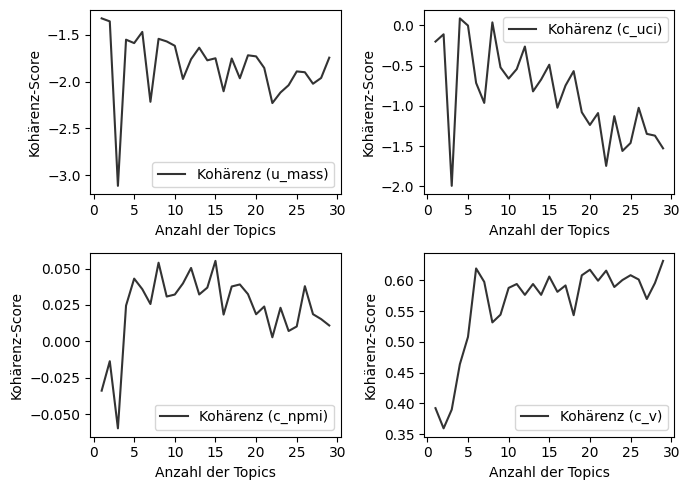

In [43]:
if calculate_coherence:
  plot_coherence_scores(coherence_values_cv, coherence_values_u_mass, coherence_values_c_uci, coherence_values_c_npmi)

#### 5.2.4 Save and download the model

In [44]:
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# Create the path for the saved model file
path = 'filtered_by_' + filter_type + '_tomotopy_lda_' + str(num_topics) + '_topics' + '.bin'

# Save the model to a file
mdl.save(path)

# Create a button for downloading the model
download_button = widgets.Button(description="Download Model")

# Link the download function to the button click event
def on_download_button_click(b):
    # Download the model file
    files.download(path)

download_button.on_click(on_download_button_click)

# Display the download button
display(download_button)

Button(description='Download Model', style=ButtonStyle())

# 6. Dynamic Topic Modeling


*   gensim or tomotopy framework can be used (default: tomotopy)




## 6.1 DTM Model (tomotopy)

### 6.1.1 Setting up model

* Use pretrained model (optional)

In [45]:
# Select trained DTM models
dtm_models_pretrained = [file for file in os.listdir('/content/repository_folder/trained_models') if "dtm" in file.lower()]

# Dropdown widget
dropdown_dtm = widgets.Dropdown(
    options=dtm_models_pretrained,
    description='Select Trained Model:',
    disabled=False,
    layout={'width': '500px'},
    style={'description_width': 'auto'}
)

# Add default option
additional_option = ""
dropdown_dtm.options = [additional_option] + list(dropdown_dtm.options)

# Display dropdown
display(dropdown_dtm)

Dropdown(description='Select Trained Model:', layout=Layout(width='500px'), options=('',), style=DescriptionSt…

In [46]:
import tomotopy as tp

# Train new model
if dropdown_dtm.value == "":
  # Create DTM model
  dtmdl = tp.DTModel(k=num_topics,
                    t=len(docs_by_year), # the number of timpoints
                    min_cf=min_cf, # minimum collection frequency of words, words with a smaller collection frequency are excluded
                    min_df=min_df, # minimum document frequency of words, words with a smaller document frequency are excluded
                    seed=seed # random seed
                    )

  # Function for adding documents to model
  def add_documents_for_timepoint(model, timepoint, doc_token_lists):
      for doc in doc_token_lists:
          model.add_doc(doc, timepoint=timepoint, ignore_empty_words=True)

  # Starting timepoint
  timepoint = 0

  # Iterate through the dictionary and add documents for each timepoint
  for year in docs_by_year:
      add_documents_for_timepoint(dtmdl, timepoint, docs_by_year[year])
      timepoint += 1

  # Train the model
  dtmdl.train(1000)
# Use pretrained model
else:
  dtmdl = tp.DTModel.load('/content/repository_folder/trained_models/' + dropdown_dtm.value)

<ipython-input-46-fad09936e3c8>:27: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  dtmdl.train(1000)


* Monitoring training process (disabled by default)

In [47]:
'''
print('Num docs:', len(dtmdl.docs), ', Vocab size:', len(dtmdl.used_vocabs), ', Num words:', dtmdl.num_words)
print('Removed top words:', dtmdl.removed_top_words)
for i in range(0, 1000, 10):
    dtmdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, dtmdl.ll_per_word))
'''

"\nprint('Num docs:', len(dtmdl.docs), ', Vocab size:', len(dtmdl.used_vocabs), ', Num words:', dtmdl.num_words)\nprint('Removed top words:', dtmdl.removed_top_words)\nfor i in range(0, 1000, 10):\n    dtmdl.train(10)\n    print('Iteration: {}\tLog-likelihood: {}'.format(i, dtmdl.ll_per_word))\n"

* Printing topic words

In [48]:
# Extract top words for each topic
top_words_by_topic = []
for k in range(mdl.k):
    topic_words = [word for word, prob in mdl.get_topic_words(k, top_n=num_keywords)]
    top_words_by_topic.append(topic_words)


# Output the top words for each topic
for k, topic_words in enumerate(top_words_by_topic):
    print("== Topic #{} ==".format(k))
    print(', '.join(topic_words))
    print()

== Topic #0 ==
environment, professional, write, native_level, fluently, ability_speak, minimum_year, enterprise_software, executive, saas, c_level, business_acumen, technology, verbal, strategic, innovative_enterprise, market, development, deadline, self_starter

== Topic #1 ==
sap, organization, project_management, bachelor_degree, effective_communication, different_level, environment, module, information_system, integration, working_global, ability_translate, analysis, related_discipline, environment_virtual, agile_devops, engineering, functional_area, information_risk, using_design

== Topic #2 ==
data, technology, sql, software, computer_science, development, technical, python, engineering, cloud, design, automation, agile, database, architecture, environment, analytics, java, framework, analysis

== Topic #3 ==
german_language, communication, analytical_skill, master_degree, project, professional, french, science, economics, international, information, project_management, busines

### 6.1.2 Topic distribution over time (DTM)

* Extract average topic distribution by year

In [49]:
# Extract topic distribution for all documents
topic_distributions_dtm = [list(doc.get_topic_dist()) for doc in dtmdl.docs]

# Extract average topic distribution by year
topic_distributions_by_year_dtm = calculate_topic_distributions_average(topic_distributions_dtm, time_slices)

* Visualisation of topic distribution over time

In [50]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Extracting time slices and average values
years = list(topic_distributions_by_year_dtm.keys())
average_values = [topic_distributions_by_year_dtm[key] for key in years]

# Converting average values into a list per topic
average_values = list(zip(*average_values))

# Creating a multi-select list for topics
topic_multiselect = widgets.SelectMultiple(
    options=[(f'Topic {i}', i) for i, _ in enumerate(average_values)],
    value=list(range(len(average_values))),  # Select all topics by default
    description='Topics:'
)

def plot_topic_distribution(selected_topics):
    plt.figure(figsize=(10, 5))

    # Colors
    color_palette = sns.color_palette("husl", len(selected_topics))

    for i, selected_topic in enumerate(selected_topics):
        # Create a plot for each selected topic
        topic_values = average_values[selected_topic]
        plt.plot(years, topic_values, label=f'Topic {selected_topic}', color=color_palette[i])  # Plot the topic's average values over the years

    plt.xlabel('Year')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)

    # Setting x-axis ticks only for full years
    plt.xticks(years)

    plt.show()

# Linking the multi-select list to the plot function
interact(plot_topic_distribution, selected_topics=topic_multiselect)

# Output the top words for each topic
for k, topic_words in enumerate(top_words_by_topic):
    print("== Topic #{} ==".format(k))
    print(', '.join(topic_words))
    print()

interactive(children=(SelectMultiple(description='Topics:', index=(0, 1, 2, 3, 4, 5, 6), options=(('Topic 0', …

== Topic #0 ==
environment, professional, write, native_level, fluently, ability_speak, minimum_year, enterprise_software, executive, saas, c_level, business_acumen, technology, verbal, strategic, innovative_enterprise, market, development, deadline, self_starter

== Topic #1 ==
sap, organization, project_management, bachelor_degree, effective_communication, different_level, environment, module, information_system, integration, working_global, ability_translate, analysis, related_discipline, environment_virtual, agile_devops, engineering, functional_area, information_risk, using_design

== Topic #2 ==
data, technology, sql, software, computer_science, development, technical, python, engineering, cloud, design, automation, agile, database, architecture, environment, analytics, java, framework, analysis

== Topic #3 ==
german_language, communication, analytical_skill, master_degree, project, professional, french, science, economics, international, information, project_management, busines

### 6.1.3 Model Evaluation

* Calculate coherence using various coherence measures

In [51]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(dtmdl, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k, timepoint=5) for k in range(dtmdl.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
Average: -1.0169489889293823 
Per Topic: [-0.8343247399402953, -1.0670180783568999, -0.9878562197048072, -1.0856000751866084, -0.9424340949127858, -1.0119631638205182, -0.9604485884450573]

==== Coherence : c_uci ====
Average: -0.07469712447554712 
Per Topic: [-0.08050078484616136, -0.1156324317013903, -0.05615739159224216, -0.1050883230843287, -0.03022785160732022, -0.12422090366396348, -0.07123658234058484]

==== Coherence : c_npmi ====
Average: -0.006625971783009807 
Per Topic: [-0.008421861652178779, -0.015929975845698434, 0.00048412820445384563, -0.013990315251770167, 0.005616204593002457, -0.017586715668995934, -0.007205111287917731]

==== Coherence : c_v ====
Average: 0.4098545252844426 
Per Topic: [0.4418476026505232, 0.39095883499830963, 0.3682663820683956, 0.41022137403488157, 0.3754988327622414, 0.4287936307489872, 0.3822625268250704]



* Calculate coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

In [52]:
import tomotopy as tp
if calculate_coherence:
  # Lists for storing coherence
  dtm_coherence_values_cv = []
  dtm_coherence_values_u_mass = []
  dtm_coherence_values_c_uci = []
  dtm_coherence_values_c_npmi = []


  for num_topics_coherence in range(2, 30, 1):

      # Create DTM model
      dtmdl_for_coherence = tp.DTModel(k=num_topics_coherence, t=len(docs_by_year), min_cf=min_cf, min_df=min_df, seed=seed)

      # Starting timepoint
      timepoint = 0

      # Iterate through the dictionary and add documents for each timepoint
      for year in docs_by_year:
          add_documents_for_timepoint(dtmdl_for_coherence, timepoint, docs_by_year[year])
          timepoint += 1

      # Train the model
      dtmdl_for_coherence.train(1000)

      # Calculation of coherence with the u_mass coherence model
      coh = tp.coherence.Coherence(dtmdl_for_coherence, coherence='u_mass')
      dtm_coherence_u_mass = coh.get_score()
      dtm_coherence_values_u_mass.append(dtm_coherence_u_mass)

      # Calculation of coherence with the c_npmi coherence model
      coh = tp.coherence.Coherence(dtmdl_for_coherence, coherence='c_uci')
      dtm_coherence_c_uci = coh.get_score()
      dtm_coherence_values_c_uci.append(dtm_coherence_c_uci)

      # Calculation of coherence with the c_npmi coherence model
      coh = tp.coherence.Coherence(dtmdl_for_coherence, coherence='c_npmi')
      dtm_coherence_c_npmi = coh.get_score()
      dtm_coherence_values_c_npmi.append(dtm_coherence_c_npmi)

      # Calculation of coherence with the c_v coherence model
      coh = tp.coherence.Coherence(dtmdl_for_coherence, coherence='c_v')
      dtm_coherence_cv = coh.get_score()
      dtm_coherence_values_cv.append(dtm_coherence_cv)

<ipython-input-52-6c55cc6b6b6c>:24: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  dtmdl_for_coherence.train(1000)


* Visualisation of coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

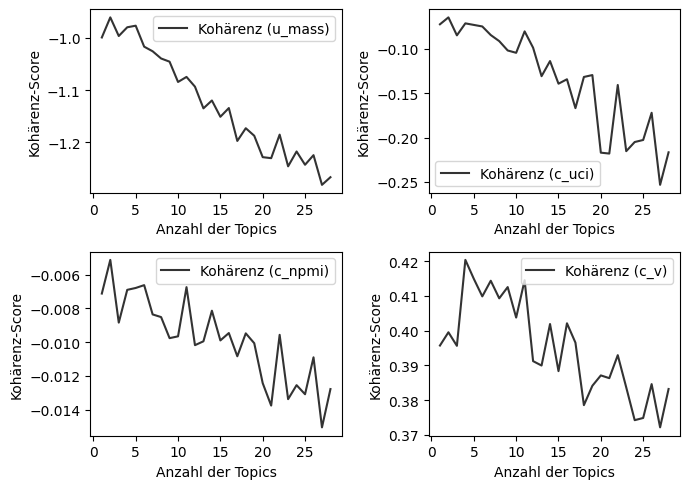

In [53]:
if calculate_coherence:
  plot_coherence_scores(dtm_coherence_values_cv, dtm_coherence_values_u_mass, dtm_coherence_values_c_uci, dtm_coherence_values_c_npmi)

### 6.1.4 Save and download the model

In [81]:
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# Create the path for the saved model file
path = 'filtered_by_' + filter_type + '_tomotopy_dtm_' + str(num_topics) + '_topics' + '.bin'

# Save the model to a file
dtmdl.save(path)

# Create a button for downloading the model
download_button = widgets.Button(description="Download Model")

# Link the download function to the button click event
def on_download_button_click(b):
    # Download the model file
    files.download(path)

download_button.on_click(on_download_button_click)

# Display the download button
display(download_button)

Button(description='Download Model', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7. Other Models & Frameworks (not in use by default)

* LDA Topic Modeling (overall, individually for each year) (gensim)
* Dynamic Topic Modeling (lda-over-time)


## 7.1 LDA Topic Modeling (gensim) (deactived by default)


### 7.1.1 Setting model parameter

In [55]:
import numpy as np
# Set additional training parameters for gensim
chunksize = 5000 # Sets the number of documents used in each chunk during training to avoid memory issues
passes = 20 # Sets the number of training passes to improve the model accuracy
iterations = 400 # Sets the maximum number of iterations during the inference process for each document, which determines the accuracy of the model

# Set training parameters
num_topics = num_topics # Specifies the number of topics to be extracted from the corpus

# Number of keywords per topic to display
num_keywords = num_keywords

# Setting the seed to ensure the reproducibility of the results
seed = seed
np.random.seed(seed)

### 7.1.2 Train LDA model (gensim) (all data)


*   used gensim for lda topic modeling, bag of words and tfidf can be selected


In [56]:
!pip install gensim --quiet
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel

# Create dictionary representation of the documents
dictionary = Dictionary(filtered_docs_all)

# Remove words that appear in fewer than 10 documents or in more than 80% of the documents (deactivated by default)
dictionary.filter_extremes(no_below=10, no_above=0.8)

# Option #1: Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in filtered_docs_all]

# Option #2: TF-IDF representation of the documents (deactivated by default)
#tfidf = TfidfModel(corpus)
#corpus = tfidf[corpus]

# Make an index to word dictionary
temp = dictionary[0]  # Used only to "load" the dictionary
id2word = dictionary.id2token

# Lda model
gensim_lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    random_state=seed
)

# Calculation of Coherence
coherence_model_lda = CoherenceModel(model=gensim_lda_model, texts=filtered_docs_all,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence (c_v):', coherence_lda)

# Calculation of Perplexity
perplexity_lda = gensim_lda_model.log_perplexity(corpus)
print('Perplexity:', perplexity_lda)

Coherence (c_v): 0.3782760337670193
Perplexity: -6.3229110469231555


### 7.1.3 Display topics and topic keywords

In [58]:
import pandas as pd
from IPython.display import display, HTML

# Extract the top keywords for each topic
topics = gensim_lda_model.show_topics(num_topics=num_topics, num_words=num_keywords, formatted=False)

# Create a table with the topics and keywords
table_data = []
for topic_id, topic_words in topics:
    keywords = [word for word, _ in topic_words]
    table_data.append([f"Topic {topic_id}", ", ".join(keywords)])

# Sort the table by topic index
table_data.sort(key=lambda x: int(x[0].split()[1]))

# Create the dataframex
df = pd.DataFrame(table_data, columns=["Topic", "Keywords"])

# Set the width of the "Keywords" column
pd.set_option("display.max_colwidth", 250)

# Display table
display(df)

# Print topics with probabilities
#for idx, topic in model.print_topics(-1):
    #print(f'Topic: {idx} \nWords: {topic}\n')

,Topic,Keywords
0,Topic 0,"business, management, process, team_player, english_language, communication, project, analytical_skill, environment, professional, technology, german_language, technical, master_degree, development, engineering, project_management, data, business..."
1,Topic 1,"process, business, team_player, english_language, communication, german_language, project, professional, management, study, strength, automation, economics, analytical_skill, science, sap, service, computer_science, partner, international"
2,Topic 2,"technology, development, software, technical, english_language, communication, design, agile, security, java, team_player, environment, computer_science, management, cloud, software_development, university_degree, javascript, framework, service"
3,Topic 3,"business, environment, communication, process, analytical_skill, management, english_language, team_player, verbal, microsoft_excel, organizational, technology, data, proficiency, technical, development, interpersonal_skill, bachelor_degree, word..."
4,Topic 4,"sap, marketing, communication, english_language, salesforce, management, digital, professional, module, service, highly, fluently, minimum_year, verbal, sap_fi, supervision, integration, proactive, customer_service, write"
5,Topic 5,"business, process, english_language, engineering, organization, management, team_player, bachelor_degree, sap, different_level, environment, effective_communication, project_management, information_system, master_degree, working_global, environme..."
6,Topic 6,"data, sql, business, english_language, computer_science, analytics, engineering, python, technology, analysis, master_degree, management, environment, r, french, process, quantitative, statistic, software, communication"


### 7.1.4 Export topic visualisation with pyldavis (all data)

In [59]:
# Visualization of topics
visualization_with_vis(gensim_lda_model, corpus, dictionary,'overall')

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


### 7.1.5 Visualisation of the probabilities of topics over years



*   Calculate probabilities




In [60]:
import numpy as np
# List of years
years = docs_by_year.keys()

# Save topic distribution for each year
topic_distributions_lda_gensim = {}

# Extract topic distribution for each year
for year in years:
    documents = docs_by_year[year]  # List of documents for the current year

    # Convert documents to BoW format for the LDA model
    year_corpus = [dictionary.doc2bow(document) for document in documents]

    # Extract topic distribution for each document of the current year
    topic_distribution_year = []
    for document in year_corpus:
        topic_probs = np.zeros(gensim_lda_model.num_topics)
        topic_distribution = gensim_lda_model.get_document_topics(document)
        for topic, prob in topic_distribution:
            topic_probs[topic] = prob
        topic_distribution_year.append(topic_probs)

    topic_distributions_lda_gensim[year] = topic_distribution_year

# Create an array to store influence scores for each year and topic
influence_scores = {}

for year in years:
    influence_scores[year] = np.zeros(gensim_lda_model.num_topics)
    for topic in range(gensim_lda_model.num_topics):
        topic_probs = np.array(topic_distributions_lda_gensim[year])[:, topic]
        influence_scores[year][topic] = np.mean(topic_probs)

*   Visualize the topic probabilities over the years
  *   Each subplot represents a topic and contains a line plot showing the probability scores of the topic over the years



interactive(children=(SelectMultiple(description='Topics:', index=(0, 1, 2, 3, 4, 5, 6), options=(('Topic 0', …

<function __main__.plot_topic_distribution(selected_topics)>

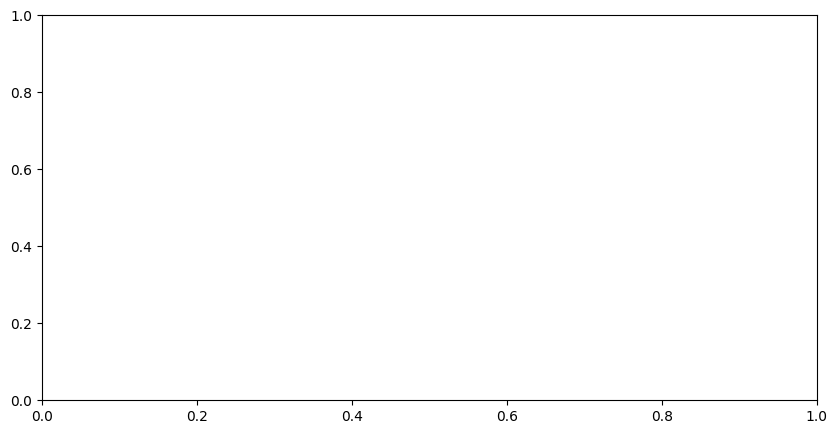

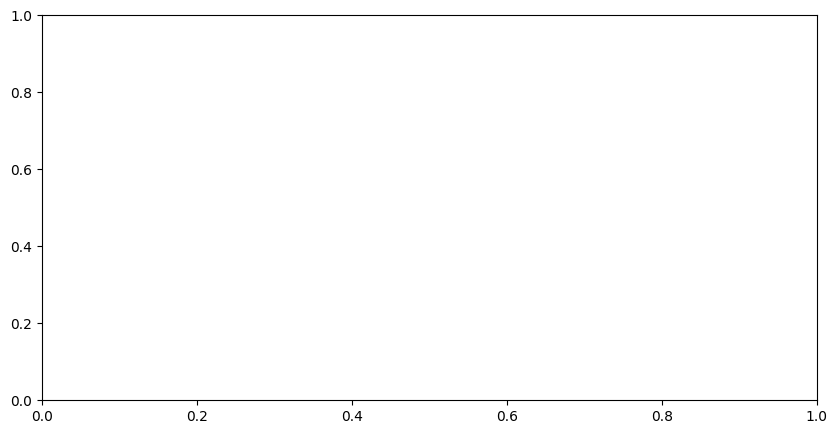

In [61]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Extracting time slices and average values
years = list(influence_scores.keys())  # Get a list of years
average_values = [influence_scores[key] for key in years]  # Get average values for each year

# Converting average values into a list per topic
average_values = list(zip(*average_values))  # Transpose the data to group values by topic

# Creating a multi-select list for topics
topic_multiselect = widgets.SelectMultiple(
    options=[(f'Topic {i}', i) for i, _ in enumerate(average_values)],  # Create options for each topic
    value=list(range(len(average_values))),  # Select all topics by default
    description='Topics:'
)

def plot_topic_distribution(selected_topics):
    plt.figure(figsize=(10, 5))  # Create a new figure with a specified size

    # Colors
    color_palette = sns.color_palette("husl", len(selected_topics))

    for i, selected_topic in enumerate(selected_topics):
        # Create a plot for each selected topic
        topic_values = average_values[selected_topic]
        plt.plot(years, topic_values, label=f'Topic {selected_topic}', color=color_palette[i])  # Plot the topic's average values over the years

    plt.xlabel('Jahr')  # Set the label for the x-axis
    plt.ylabel('Probability')  # Set the label for the y-axis
    plt.legend()  # Show legend with topic labels
    plt.grid(True)  # Display grid lines

    # Set x-axis ticks only for full years
    plt.xticks(years)

    plt.show()  # Show the plot

# Link the multi-select list with the plot function using interact
interact(plot_topic_distribution, selected_topics=topic_multiselect)

### 7.1.6 Evaluation of the model

* Calculate coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

In [62]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

if calculate_coherence:
  # Lists for storing coherence
  gensim_lda_coherence_values_cv = []
  gensim_lda_coherence_values_u_mass = []
  gensim_lda_coherence_values_c_uci = []
  gensim_lda_coherence_values_c_npmi = []


  for num_topics_coherence in range(1, 30, 1):

      # Convert documents to BoW format for the LDA model
      gensim_lda_for_coherence_dictionary = corpora.Dictionary(filtered_docs_all)

      # Remove words that appear in fewer than 10 documents or in more than 80% of the documents (activated by default)
      dictionary.filter_extremes(no_below=10, no_above=0.8)

      # Define the corpus
      gensim_lda_for_coherence_corpus = [dictionary.doc2bow(document) for document in filtered_docs_all]

      # Train the LDA model on the entire corpus
      gensim_lda_for_coherence = LdaModel(
          corpus=gensim_lda_for_coherence_corpus,
          id2word=gensim_lda_for_coherence_dictionary,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=num_topics_coherence,
          passes=passes,
          random_state=seed
      )

      # Calculation of coherence with the u_mass coherence model
      coh = CoherenceModel(model=gensim_lda_for_coherence, corpus=gensim_lda_for_coherence_corpus, coherence='u_mass')
      gensim_lda_coherence_u_mass = coh.get_coherence()
      gensim_lda_coherence_values_u_mass.append(gensim_lda_coherence_u_mass)

      # Calculation of coherence with the c_npmi coherence model
      coh = CoherenceModel(model=gensim_lda_for_coherence, texts=filtered_docs_all, dictionary=gensim_lda_for_coherence_dictionary, coherence='c_uci')
      gensim_lda_coherence_c_uci = coh.get_coherence()
      gensim_lda_coherence_values_c_uci.append(gensim_lda_coherence_c_uci)

      # Calculation of coherence with the c_npmi coherence model
      coh = CoherenceModel(model=gensim_lda_for_coherence, texts=filtered_docs_all, dictionary=gensim_lda_for_coherence_dictionary, coherence='c_npmi')
      gensim_lda_coherence_c_npmi = coh.get_coherence()
      gensim_lda_coherence_values_c_npmi.append(gensim_lda_coherence_c_npmi)

      # Calculation of coherence with the c_v coherence model
      coh = CoherenceModel(model=gensim_lda_for_coherence, texts=filtered_docs_all, dictionary=gensim_lda_for_coherence_dictionary, coherence='c_v')
      gensim_lda_coherence_cv = coh.get_coherence()
      gensim_lda_coherence_values_cv.append(gensim_lda_coherence_cv)

* Visualisation of coherence for different number of topics using various coherence measures, can be helpful to select the number of topic

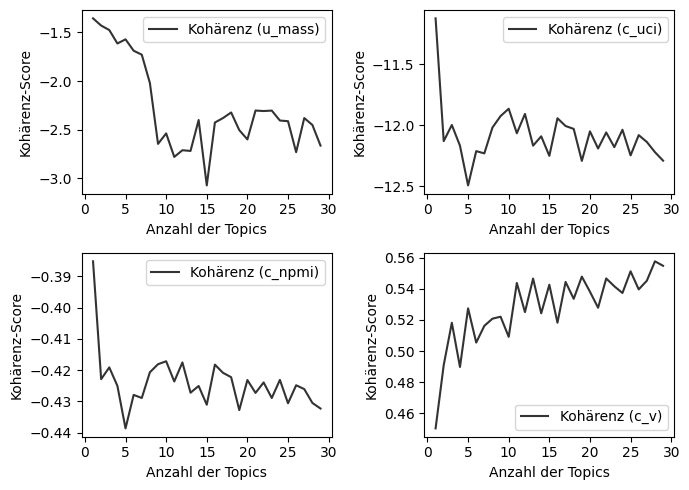

In [63]:
if calculate_coherence:
  plot_coherence_scores(gensim_lda_coherence_values_cv, gensim_lda_coherence_values_u_mass, gensim_lda_coherence_values_c_uci, gensim_lda_coherence_values_c_npmi)

### 7.1.7 Train LDA model (for each year)

In [64]:
import warnings
from gensim.models import LdaModel
from gensim.models.phrases import Phrases

# Ignore warning caused by gensim library, improve readability
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Analysis based on year
for year in docs_by_year:

  # User info
  print('Analysing job advertisement data of ' + str(year) + ' (' + str(len(docs_by_year[year])) + ')...')

  docs = docs_by_year[year]

  # Create a dictionary representation of the documents
  dictionary = Dictionary(filtered_docs_all)

  # Remove words that appear in fewer than 10 documents or in more than 80% of the documents (activated by default)
  dictionary.filter_extremes(no_below=10, no_above=0.8)

  # Bag-of-words representation of the documents
  corpus = [dictionary.doc2bow(doc) for doc in docs]


  # Make an index to word dictionary.
  temp = dictionary[0]  # Used only to "load" the dictionary
  id2word = dictionary.id2token

  # Train lda model
  lda_model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=num_topics,
      passes=passes
  )

  # Print topics
  for idx, topic in lda_model.print_topics(-1):
      print(f'Topic: {idx} \nWords: {topic}\n')

  # Topic Visualisation
  visualization_with_vis(lda_model, corpus, dictionary, str(year))

Analysing job advertisement data of 2015 (73)...
Topic: 0 
Words: 0.038*"business" + 0.025*"process" + 0.024*"management" + 0.018*"communication" + 0.015*"team_player" + 0.012*"project" + 0.011*"sap" + 0.010*"environment" + 0.009*"organization" + 0.008*"analytical_skill"

Topic: 1 
Words: 0.048*"business" + 0.033*"process" + 0.019*"regulatory" + 0.013*"communication" + 0.013*"management" + 0.011*"team_player" + 0.011*"analytical_skill" + 0.009*"functional" + 0.009*"analysis" + 0.009*"enterprise"

Topic: 2 
Words: 0.014*"practice" + 0.010*"law" + 0.010*"environment" + 0.010*"project" + 0.010*"timely" + 0.005*"finance" + 0.005*"simultaneously" + 0.005*"insurance" + 0.005*"state" + 0.005*"beneficial"

Topic: 3 
Words: 0.039*"business" + 0.018*"communication" + 0.017*"process" + 0.013*"project_management" + 0.012*"technical" + 0.012*"project" + 0.011*"environment" + 0.011*"management" + 0.011*"team_player" + 0.010*"english_language"

Topic: 4 
Words: 0.014*"analytical_skill" + 0.010*"manag

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2018 (121)...
Topic: 0 
Words: 0.028*"business" + 0.017*"science" + 0.016*"english_language" + 0.016*"process" + 0.013*"professional" + 0.011*"french" + 0.011*"communication" + 0.010*"resistance" + 0.010*"firm" + 0.010*"dutch"

Topic: 1 
Words: 0.029*"business" + 0.017*"team_player" + 0.014*"technology" + 0.013*"marketing" + 0.012*"communication" + 0.010*"english_language" + 0.010*"analytical_skill" + 0.009*"finance" + 0.009*"exceptional" + 0.008*"management"

Topic: 2 
Words: 0.018*"analytical_skill" + 0.015*"communication" + 0.014*"technology" + 0.013*"environment" + 0.013*"team_player" + 0.013*"process" + 0.012*"business" + 0.010*"attention_detail" + 0.010*"exceptional" + 0.009*"design"

Topic: 3 
Words: 0.042*"business" + 0.022*"english_language" + 0.018*"management" + 0.017*"team_player" + 0.016*"process" + 0.015*"engineering" + 0.014*"data" + 0.014*"master_degree" + 0.013*"technology" + 0.013*"communication"

Topic: 4 
Words: 0.039*"business" +

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2019 (294)...
Topic: 0 
Words: 0.023*"business" + 0.016*"data" + 0.013*"development" + 0.013*"team_player" + 0.013*"user" + 0.013*"english_language" + 0.012*"management" + 0.012*"technology" + 0.012*"process" + 0.011*"communication"

Topic: 1 
Words: 0.030*"business" + 0.017*"team_player" + 0.017*"english_language" + 0.015*"process" + 0.013*"environment" + 0.011*"employee" + 0.011*"management" + 0.011*"innovation" + 0.010*"technology" + 0.010*"professional"

Topic: 2 
Words: 0.037*"process" + 0.035*"business" + 0.027*"management" + 0.022*"english_language" + 0.019*"project" + 0.019*"team_player" + 0.016*"sap" + 0.016*"communication" + 0.015*"german_language" + 0.012*"data"

Topic: 3 
Words: 0.023*"business" + 0.021*"technology" + 0.015*"process" + 0.015*"english_language" + 0.014*"communication" + 0.014*"management" + 0.013*"data" + 0.013*"professional" + 0.013*"technique" + 0.011*"economics"

Topic: 4 
Words: 0.028*"business" + 0.017*"security" + 0.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2020 (396)...
Topic: 0 
Words: 0.027*"communication" + 0.021*"management" + 0.019*"professional" + 0.017*"english_language" + 0.016*"verbal" + 0.014*"environment" + 0.012*"technical" + 0.011*"technology" + 0.010*"salesforce" + 0.010*"business"

Topic: 1 
Words: 0.026*"data" + 0.024*"business" + 0.019*"english_language" + 0.013*"science" + 0.011*"environment" + 0.010*"highly" + 0.010*"development" + 0.010*"mathematics" + 0.010*"management" + 0.009*"sql"

Topic: 2 
Words: 0.038*"business" + 0.029*"process" + 0.023*"management" + 0.021*"english_language" + 0.019*"team_player" + 0.018*"project" + 0.016*"sap" + 0.013*"communication" + 0.012*"german_language" + 0.012*"environment"

Topic: 3 
Words: 0.032*"business" + 0.018*"management" + 0.018*"data" + 0.016*"process" + 0.014*"technology" + 0.012*"environment" + 0.010*"team_player" + 0.010*"english_language" + 0.009*"computer_science" + 0.009*"communication"

Topic: 4 
Words: 0.028*"business" + 0.021*"team

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2021 (407)...
Topic: 0 
Words: 0.025*"business" + 0.025*"team_player" + 0.017*"communication" + 0.016*"analytical_skill" + 0.015*"english_language" + 0.013*"management" + 0.011*"environment" + 0.011*"process" + 0.010*"technical" + 0.009*"technology"

Topic: 1 
Words: 0.031*"project" + 0.025*"business" + 0.021*"management" + 0.017*"process" + 0.015*"communication" + 0.013*"environment" + 0.013*"research" + 0.012*"team_player" + 0.010*"program" + 0.010*"data"

Topic: 2 
Words: 0.047*"business" + 0.032*"process" + 0.021*"sap" + 0.019*"environment" + 0.018*"english_language" + 0.017*"management" + 0.013*"organization" + 0.009*"automation" + 0.008*"finance" + 0.008*"project_management"

Topic: 3 
Words: 0.025*"data" + 0.021*"english_language" + 0.019*"technology" + 0.019*"business" + 0.018*"management" + 0.017*"process" + 0.015*"engineering" + 0.013*"communication" + 0.013*"computer_science" + 0.011*"environment"

Topic: 4 
Words: 0.030*"business" + 0.021

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2022 (102)...
Topic: 0 
Words: 0.028*"business" + 0.017*"team_player" + 0.014*"technical" + 0.014*"process" + 0.013*"communication" + 0.013*"english_language" + 0.011*"software" + 0.011*"engineering" + 0.009*"technology" + 0.009*"german_language"

Topic: 1 
Words: 0.044*"business" + 0.029*"process" + 0.028*"management" + 0.020*"english_language" + 0.016*"communication" + 0.011*"analysis" + 0.010*"team_player" + 0.010*"german_language" + 0.010*"environment" + 0.009*"agile"

Topic: 2 
Words: 0.025*"business" + 0.019*"technology" + 0.017*"master_degree" + 0.014*"computer_science" + 0.013*"environment" + 0.013*"english_language" + 0.012*"data" + 0.012*"management" + 0.012*"team_player" + 0.010*"process"

Topic: 3 
Words: 0.017*"analytical_skill" + 0.017*"management" + 0.016*"business" + 0.013*"process" + 0.013*"analysis" + 0.012*"team_player" + 0.012*"communication" + 0.012*"environment" + 0.010*"data" + 0.009*"english_language"

Topic: 4 
Words: 0.034*"

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


## 7.2. Dynamic Topic Modeling (lda-over-time)

Implemented with lda_over_time framework. Two differnet LDA models can be used:


1.   Temporal LDA Model

*   inferior results but significantly lower runtime


2.   LDA Seq Model (used by default)


  *   better results but significantly higher runtime


Per default tomotopy framework is used (cf. 5. & 6.)  because lda_over_time framework assigns only one topic to each document, the one with the highest probability, it continues processing with that topic. However, this is not entirely accurate, as one description may encompass multiple groups of skills

###7.2.1 Set number of topics




In [65]:
n_topics = num_topics

###7.2.2 Generate timestamp for each document and convert documents

In [99]:
import pandas as pd

timestamps_by_year = []

# Generates year-based timestamps for all documents
for year, docs in docs_by_year.items():
    timestamps = []
    for doc in docs:
        timestamp = year
        timestamps.append(str(year))
    timestamps_by_year += (timestamps)

# Converts words in lists into a single string, needed for topic over time model
docs = [" ".join(doc) for doc in filtered_docs_all]

In [100]:
print(timestamps_by_year)

['2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018', '2018',

###7.2.3 Install lda-over-time

In [67]:
!pip install lda-over-time --quiet

###7.2.4 Setting up Temporal LDA Model

In [68]:
from lda_over_time.lda_over_time import LdaOverTime
from lda_over_time.models.temporal_lda_model import TemporalLdaModel

temporal_lda_model = TemporalLdaModel(
    corpus = docs,         # list texts to be analysed
    dates = timestamps_by_year,     # dates of each article
    date_format = "%Y",        # date format is MM/DD/YYYY
    freq = "12M",                     # frequency of one semester
    n_topics = n_topics,                    # we want to get 5 topics
    aggregator = "average"           # calculate average of topics
)

###7.2.5 Setting up LDA Seq Model (used by default)

In [69]:
from lda_over_time.lda_over_time import LdaOverTime
from lda_over_time.models.lda_seq_model import LdaSeqModel


lda_seq_model = LdaSeqModel(
    corpus = docs,         # list texts to be analysed
    dates = timestamps_by_year,     # dates of each article
    date_format = "%Y",        # date format is MM/DD/YYYY
    freq = "12M",                     # frequency of one semester
    n_topics = n_topics,                    # we want to get 5 topics
)

###7.2.6 Train the dynamic LDA model

In [70]:
# Train LDA Over Time model
main = LdaOverTime(lda_seq_model)

# Load pretrained model (disabled by default)
path = '/content/drive/MyDrive/lda_over_time/filter_by_' + filter_type + '_tn_' + str(n_topics)
#main = main.load(path)

# Print topic keywords for each topic
for i in range(n_topics):
  print(main.get_topic_words(topic_id=i, timeslice=len(year_dfs), n=15))

['process', 'business', 'management', 'team_player', 'communication', 'english_language', 'project', 'german_language', 'environment', 'analytical_skill', 'professional', 'sap', 'project_management', 'development', 'technical']
['business', 'data', 'team_player', 'analytical_skill', 'english_language', 'master_degree', 'engineering', 'management', 'french', 'technology', 'communication', 'environment', 'dutch', 'computer_science', 'technical']
['management', 'communication', 'data', 'marketing', 'english_language', 'project', 'technology', 'technical', 'salesforce', 'design', 'security', 'verbal', 'professional', 'digital', 'analysis']
['business', 'process', 'analytical_skill', 'communication', 'project', 'partner', 'english_language', 'management', 'research', 'computer_science', 'german_language', 'technical', 'business_administration', 'technology', 'value']
['business', 'english_language', 'data', 'technology', 'environment', 'process', 'sql', 'team_player', 'computer_science', 's

###7.2.7 Rename topics (optional)

In [71]:
# Topic names
#topic_names = ['Projekt Management', 'Computer Science & Automation', 'Kommunikation & Sprachen', 'Data Analytics', 'Informatik & analytisches Denken', 'Verwaltung', 'Soft Skills', 'Reisebereitschaft', 'Akademische Bildung', 'Problemlösung & Economics', 'Technische Fähigkeiten', 'Service']

# Rename Topics
#main.rename_topics(topic_names)


###7.2.8 Visualization of topic probability over years

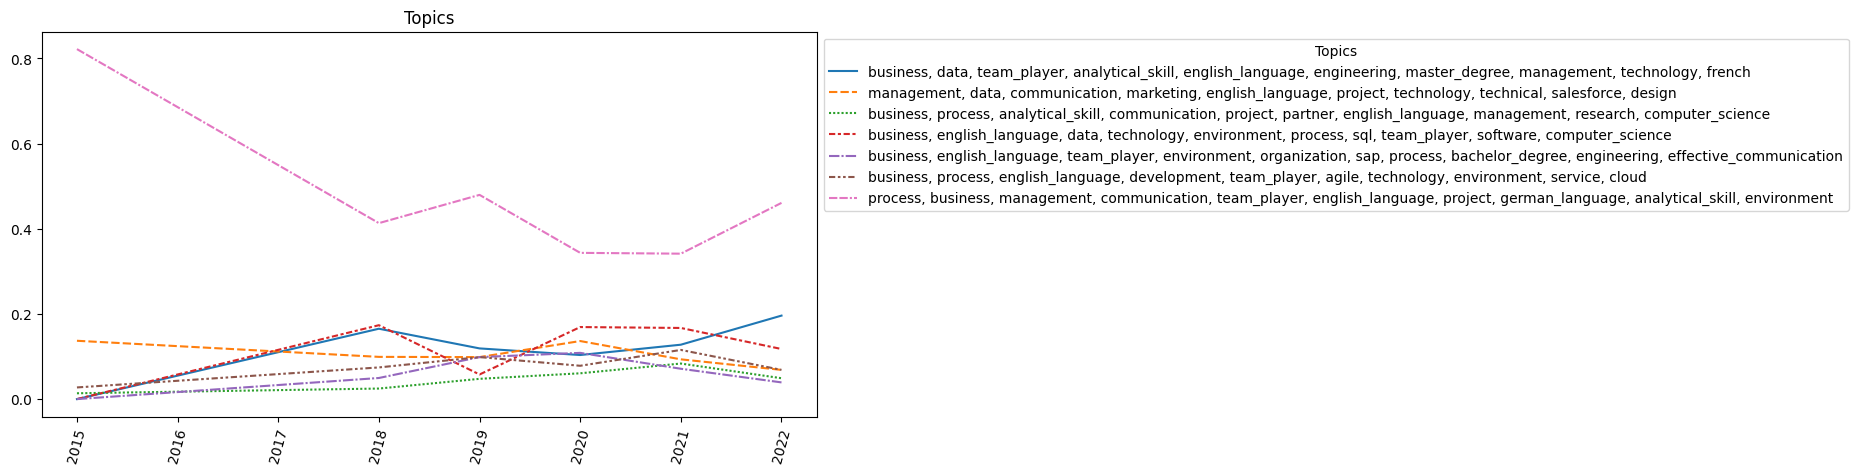

In [72]:
# Visualisation of the topics and their development over the years
fig, ax = plt.subplots(figsize=(10, 5))
main.plot(

    # Plot's title
    title = 'Topics',

    # Legend's title
    legend_title="Topics",

    # Set location to save
    # path_to_save="./plot_of_news.png",

    # Display graph (default)
    display=True,

    # Rotate labels in 75º
    rotation=75,

    # Plot lines (default)
    mode="line",

    # Set custom date format to YYYY
    date_format="%Y"
)

###7.2.9 Save the developed lda-over-time model

In [88]:
path = '/content/filter_by_' + filter_type + '_lda_over_time_' + str(n_topics) + '_topics'
main.save(path)